In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection  import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

In [3]:
path = "D:/LG_Radar"
train = pd.read_csv(path+"/train.csv")
test = pd.read_csv(path+"/test.csv")
submission = pd.read_csv(path+"/sample_submission.csv")

In [4]:
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(14): # ignore 'ID'
        rmse = mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:14])
    print(all_nrmse)
    return score

In [5]:
train

,ID,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,...,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TRAIN_00001,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,...,29.632,16.083,4.276,-25.381,-25.529,-22.769,23.792,-25.470,-25.409,-25.304
1,TRAIN_00002,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,...,33.179,16.736,3.229,-26.619,-26.523,-22.574,24.691,-26.253,-26.497,-26.438
2,TRAIN_00003,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,...,31.801,17.080,2.839,-26.238,-26.216,-22.169,24.649,-26.285,-26.215,-26.370
3,TRAIN_00004,71.563,103.320,67.57,1,101.971,77.022,28.92,115.21,255.36,...,34.503,17.143,3.144,-25.426,-25.079,-21.765,24.913,-25.254,-25.021,-25.345
4,TRAIN_00005,69.524,103.320,63.57,1,101.981,70.904,29.68,103.38,241.46,...,32.602,17.569,3.138,-25.376,-25.242,-21.072,25.299,-25.072,-25.195,-24.974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39602,TRAIN_39603,66.465,103.320,62.27,1,103.150,66.825,30.20,77.83,298.05,...,29.194,16.582,3.410,-26.486,-26.581,-22.772,24.261,-26.491,-26.584,-26.580
39603,TRAIN_39604,66.465,103.321,62.77,1,102.021,66.825,29.21,102.25,270.67,...,29.859,15.659,3.406,-27.308,-27.203,-24.674,23.427,-27.250,-27.334,-27.325
39604,TRAIN_39605,68.504,103.320,64.67,1,103.144,68.864,29.96,102.61,198.07,...,24.720,16.823,3.215,-26.502,-26.687,-22.577,24.301,-26.388,-26.425,-26.601
39605,TRAIN_39606,66.465,103.320,63.67,1,102.025,67.845,30.30,112.60,275.52,...,26.412,15.757,4.216,-26.760,-26.634,-24.066,23.305,-26.536,-26.751,-26.635


In [6]:
train.columns

Index(['ID', 'X_01', 'X_02', 'X_03', 'X_04', 'X_05', 'X_06', 'X_07', 'X_08',
       'X_09', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15', 'X_16', 'X_17',
       'X_18', 'X_19', 'X_20', 'X_21', 'X_22', 'X_23', 'X_24', 'X_25', 'X_26',
       'X_27', 'X_28', 'X_29', 'X_30', 'X_31', 'X_32', 'X_33', 'X_34', 'X_35',
       'X_36', 'X_37', 'X_38', 'X_39', 'X_40', 'X_41', 'X_42', 'X_43', 'X_44',
       'X_45', 'X_46', 'X_47', 'X_48', 'X_49', 'X_50', 'X_51', 'X_52', 'X_53',
       'X_54', 'X_55', 'X_56', 'Y_01', 'Y_02', 'Y_03', 'Y_04', 'Y_05', 'Y_06',
       'Y_07', 'Y_08', 'Y_09', 'Y_10', 'Y_11', 'Y_12', 'Y_13', 'Y_14'],
      dtype='object')

In [7]:
X = train[list(train.columns[1:57])]
y = train[list(train.columns[57:])]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, np.array(y))

# XGBResressor

In [8]:
pred = []
models= []
for i in range(14):
    model = XGBRegressor()
    model.fit(X_train, y_train[:,i])
    pred.append(model.predict(X_test[list(X_test.columns)]))
    models.append(model)

C:\Users\hjhhi\anaconda3\envs\python3.9.0\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\hjhhi\anaconda3\envs\python3.9.0\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\hjhhi\anaconda3\envs\python3.9.0\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\hjhhi\anaconda3\envs\python3.9.0\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.

In [12]:
def prediction(X):
    pred=[]
    for i in range(14):
        pred.append(models[i].predict(X[list(X.columns)]))
    return np.transpose(pred)

In [13]:
pred = prediction(X_test)

In [14]:
lg_nrmse(np.array(y_test),pred)

[0.2628051302141368, 0.36337473869068826, 0.3596614229680816, 0.19329970484581827, 0.08115774306045123, 0.1072757132045397, 0.1313353107968666, 0.024628517821905584, 0.02437679150926346, 0.03887366174856646, 0.03425848916637719, 0.02446206931057224, 0.02440613343266399, 0.024572832941537743]


1.9991959160319668

In [16]:
GridSearchCV?

In [ ]:
cv_params = {
    'max_depth': np.arange(1, 10, 1), 
    'min_child_weight': np.arange(1, 4, 1),
    'learning_rate': np.arange(0.05, 0.6, 0.05),
    'n_estimators': np.arange(50, 300, 50),
}    # parameters to be tries in the grid search

fix_params = {
   'booster': 'gbtree',
#     'objective': 'binary:logistic',
#     'learning_rate': 0.03,
#     'n_estimators': 150,
#     'reg_alpha' : 0.15,
#     'reg_lambda': 0.7,
#     'max_depth': 4,
}   #other parameters, fixed for the moment 

csv = GridSearchCV(XGBClassifier(**fix_params), 
                   cv_params, 
                   scoring = 'neg_root_mean_squared_error', 
                   cv = 5,
                  n_jobs=11)
csv.fit(x_train, y_train)
# show best cross validation score
print(csv.best_score_)
# show best parameter score
print(csv.best_params_)

# make predictions for test data
y_pred = csv.predict(x_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
for parameter in csv.cv_results_["params"]:
    print(parameter)

In [31]:
pred = []
models= []
cv_params = {
    'max_depth': np.arange(1, 10, 1), 
#     'min_child_weight': np.arange(1, 3, 1),
    'learning_rate': np.arange(0.05, 0.6, 0.05),
#     'n_estimators': np.arange(50, 300, 50),
}    # parameters to be tries in the grid search

fix_params = {
    'booster': 'gbtree',
    #     'objective': 'binary:logistic',
    #     'learning_rate': 0.03,
    #     'n_estimators': 150,
    #     'reg_alpha' : 0.15,
    #     'reg_lambda': 0.7,
    #     'max_depth': 4,
}   #other parameters, fixed for the moment 

for i in range(14):
    csv = GridSearchCV(XGBRegressor(**fix_params), 
                       cv_params, 
                       scoring = 'neg_root_mean_squared_error', 
                       cv = 5,
                      n_jobs=-1,
                      verbose=2)
    csv.fit(X_train, y_train[:,i])
    models.append(csv)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits
Fitting 5 folds for each of 99 candidates, totalling 495 fits


In [37]:
for i in models:
    print(i.best_params_)

{'learning_rate': 0.05, 'max_depth': 5}
{'learning_rate': 0.05, 'max_depth': 5}
{'learning_rate': 0.05, 'max_depth': 5}
{'learning_rate': 0.1, 'max_depth': 8}
{'learning_rate': 0.1, 'max_depth': 5}
{'learning_rate': 0.05, 'max_depth': 9}
{'learning_rate': 0.05, 'max_depth': 7}
{'learning_rate': 0.1, 'max_depth': 5}
{'learning_rate': 0.1, 'max_depth': 5}
{'learning_rate': 0.1, 'max_depth': 9}
{'learning_rate': 0.1, 'max_depth': 5}
{'learning_rate': 0.1, 'max_depth': 6}
{'learning_rate': 0.1, 'max_depth': 6}
{'learning_rate': 0.1, 'max_depth': 6}


학습률은 작은값으로 튜닝하고 max_depth는 범위를 늘려 새로 튜닝하는게 좋아보임  
빠른 검증을 위해 각각의 컬럼을 하나씩 튜닝하고 점수를 체크할 예정

In [38]:
pred = prediction(X_test)

In [39]:
lg_nrmse(y_test, pred)

[0.25644896647318666, 0.35419428281316856, 0.3501462360496395, 0.18914191553947782, 0.0793762309138478, 0.09927294376409831, 0.12812724806839143, 0.024105689942841544, 0.023965628809133267, 0.038006724587326714, 0.03356862425944726, 0.024103873334016857, 0.024063642485379438, 0.024066106472503776]


1.9447508162253893

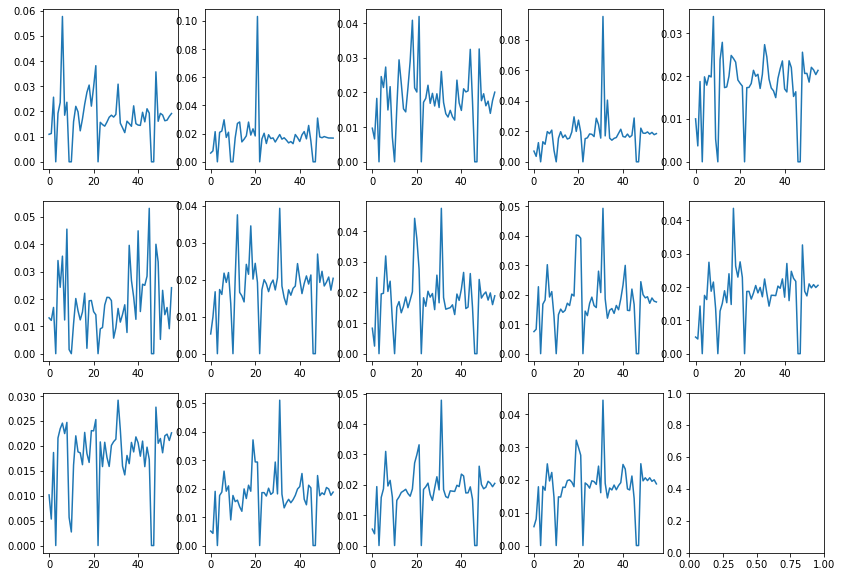

In [111]:
visualize(models)

# 2번 부터 모델을 하나씩 튜닝한다

In [9]:
y_test[1]

array([  1.6  ,   1.454,   1.359,  15.907,  36.087,  18.017,   3.23 ,
       -25.456, -25.296, -21.034,  25.882, -25.271, -25.418, -25.254])

In [10]:
test

,ID,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,...,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,TEST_00001,68.504,103.321,76.67,1,101.867,73.963,30.51,63.57,239.80,...,1,1,17227.63,138.130429,129.460682,141.506570,133.427229,129.711498,133.138096,121.859684
1,TEST_00002,67.485,103.320,69.37,1,101.992,67.845,28.03,116.99,189.23,...,1,1,17134.53,136.148839,128.266277,145.911745,131.196417,132.411480,133.629025,124.178623
2,TEST_00003,69.524,103.320,68.97,1,101.884,77.022,29.65,205.68,214.93,...,1,1,14860.83,120.447446,119.988804,132.099908,120.450155,130.051708,128.252972,114.475628
3,TEST_00004,69.524,103.320,65.87,1,101.866,73.963,28.15,103.38,180.80,...,1,1,15252.53,133.994695,125.069180,147.507669,123.142653,125.963665,139.666592,126.589253
4,TEST_00005,73.603,103.321,66.67,1,101.891,74.983,29.92,71.20,231.93,...,1,1,10752.23,137.918202,135.116192,138.600473,127.173033,137.252712,134.411335,124.020016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,TEST_39604,68.504,103.320,63.97,1,103.157,68.864,29.49,116.35,284.16,...,1,1,62123.53,127.741246,126.494312,139.119905,125.271109,128.284572,140.176945,128.292843
39604,TEST_39605,68.504,103.320,61.37,1,103.137,68.864,32.29,116.28,272.41,...,1,1,61844.13,127.767377,124.062809,138.238664,119.879393,127.322529,137.312047,131.570614
39605,TEST_39606,69.524,103.320,63.67,1,103.149,69.884,30.00,113.05,295.54,...,1,1,60277.53,128.593640,124.774037,138.659624,123.999571,126.075542,135.656132,127.671108
39606,TEST_39607,67.485,103.321,61.77,1,103.148,67.845,32.05,115.05,267.26,...,1,1,60236.73,121.110646,125.471699,134.989984,120.889578,129.296909,132.673977,131.882893


In [11]:
print(mean_squared_error(y_train[:, 1], models[1].predict(X_train[list(X_test.columns)])))
print(mean_squared_error(y_test[:, 1], models[1].predict(X_test[list(X_test.columns)])))

NameError: name 'models' is not defined

base train mse: 0.131?  
base mse: 0.1397...

In [12]:
np.mean(y_train[:, 1])

1.057096751388655

In [13]:
np.mean(y_test[:, 1])

1.0577787315693798

In [19]:
pred = []
cv_params = {
    'max_depth': np.arange(3, 7, 1), 
    'learning_rate': np.arange(0.01, 0.12, 0.02),
#     "colsample_bytree": np.arange(0.5, 1.01, 0.25),
    'n_estimators': np.arange(100, 300, 75)    
}    

fix_params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    "seed": 42,
#     "num_early_stopping_rounds": 5,
    "gpu_id": 0,
    "tree_method": "gpu_hist"
}  

cv = GridSearchCV(XGBRegressor(**fix_params), 
                   cv_params, 
                   scoring = 'neg_root_mean_squared_error', 
                   cv = 5,
                  n_jobs=-1,
                  verbose=3)
cv.fit(X_train, y_train[:,1])

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', gamma=None, gpu_id=0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                              

In [20]:
cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.060000000000000005, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, ...)

In [123]:
cv.best_params_

{'alpha': 4, 'gamma': 1, 'reg_lambda': 7}

In [22]:
print(mean_squared_error(y_train[:, 1],cv.predict(X_train[list(X_test.columns)])))
print(mean_squared_error(y_test[:, 1],cv.predict(X_test[list(X_test.columns)])))

0.13008806267158202
0.14101682888652375


In [114]:
model = XGBRegressor(learning_rate = 0.07, max_depth=5, n_estimators=300, tree_method="gpu_hist", colsample_bytree=0.75,
                    objective="reg:squarederror", gamma=0.3, reg_lambda=0.3, alpha=0.3, scale_pos_weight=0.1)
model.fit(X_train, y_train[:,1])

XGBRegressor(alpha=0.3, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.75,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.07, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.300000012, ...)

In [115]:
print(mean_squared_error(y_train[:, 1],model.predict(X_train[list(X_test.columns)])))
print(mean_squared_error(y_test[:, 1],model.predict(X_test[list(X_test.columns)])))

0.12516711335627578
0.14127976649927323


In [125]:
pred = []
cv_params = {
#     'max_depth': np.arange(3, 7, 1), 
#     'learning_rate': np.arange(0.01, 0.12, 0.02),
#     "colsample_bytree": np.arange(0.5, 1.01, 0.25),
#     'n_estimators': np.arange(100, 300, 75)   
    "gamma":np.arange(3, 5, 0.3),
    "reg_lambda":np.arange(0, 2, 0.3),
    "alpha":np.arange(6, 8, 0.3),
    
}    

fix_params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    "eval_metric": "rmse",
    "seed": 42,
#     "num_early_stopping_rounds": 5,
    "gpu_id": 0,
    "tree_method": "gpu_hist",
    "learning_rate":0.5,
    "max_depth":6,
    "n_estimators":300
}  

cv = GridSearchCV(XGBRegressor(**fix_params), 
                   cv_params, 
                   scoring = 'neg_root_mean_squared_error', 
                   cv = 5,
                  n_jobs=-1,
                  verbose=3)
cv.fit(X_train, y_train[:,1])

Fitting 5 folds for each of 343 candidates, totalling 1715 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', gamma=None, gpu_id=0,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.5, max_bin=None,
                                    max_c...
                                    monotone_constraints=None, n_estimators=300,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [126]:
cv.best_params_

{'alpha': 6.8999999999999995, 'gamma': 3.0, 'reg_lambda': 1.2}

In [127]:
print(mean_squared_error(y_train[:, 1],cv.predict(X_train[list(X_test.columns)])))
print(mean_squared_error(y_test[:, 1],cv.predict(X_test[list(X_test.columns)])))

0.14314917216849002
0.14271089026484776


# Submission

In [42]:
submission[list(submission.columns[1:])] = prediction(test[list(test.columns[1:57])])

In [43]:
submission[list(submission.columns[1:])]

,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,1.431872,1.168564,1.122446,13.323411,30.732706,16.161852,3.089605,-26.051510,-26.168472,-22.168365,24.439182,-26.186672,-26.014246,-26.034195
1,1.482981,1.177855,1.146533,13.417275,31.291752,16.535276,3.086622,-26.172918,-26.178089,-22.419561,24.422762,-26.106010,-26.051546,-26.062809
2,1.381617,1.073072,1.079412,13.683433,32.246677,16.707188,2.975574,-25.802059,-25.667589,-22.183771,24.736397,-25.690916,-25.804255,-25.815447
3,1.441587,1.145865,1.039582,14.999978,32.469048,16.957319,2.981209,-25.602610,-25.674963,-21.888788,24.877396,-25.607964,-25.519442,-25.599375
4,1.310262,1.031289,0.899140,15.033303,31.517897,16.819544,3.020349,-25.816376,-25.819689,-21.840166,24.674677,-25.802046,-25.810757,-25.733101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,1.246434,0.945124,0.949532,12.708375,31.178970,16.615458,3.150761,-26.540054,-26.486897,-22.553228,24.410305,-26.427046,-26.355572,-26.467617
39604,1.265963,0.913743,0.991946,14.474705,31.336872,16.921745,3.187699,-26.431139,-26.472315,-22.433453,24.471724,-26.422443,-26.472694,-26.346188
39605,1.183705,0.921559,0.923979,12.437606,31.413551,16.507736,3.131315,-26.583241,-26.589739,-22.840784,24.421360,-26.496462,-26.441900,-26.496752
39606,1.218740,0.892097,0.949491,13.292331,31.499372,16.675983,3.153240,-26.583809,-26.534300,-22.919586,24.494181,-26.508875,-26.386637,-26.414085


In [44]:
submission.to_csv("./xgboost.csv", index=None)